# End-to-end Multil-class MNIST Classification

This notebook builds an end-to-end multi-class image classifier using PyTorch.

## 1. Problem

Correctly identify digits from a dataset.

## 2. Data

The data we're using is from Kaggle's Digit Recognizer competition.

https://www.kaggle.com/competitions/digit-recognizer/data

## 3. Evaluation

The evaluation is a file with predicted correct label of each test image.

https://www.kaggle.com/competitions/digit-recognizer/overview/evaluation

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) each image has 784 features. this is because each image is 28*28 pixels and each feature represents one pixel's intensity 0(white) to 255(black) so it's probably best we use deep learning-CNN.
* There are 10 Labels 0-9 (this means there are 10 different classes).
* There are around 42,000 images from the kaggle dataset and 70,000 images from torchvision total of 112,000 images for trainig (these images have labels).
* There are around 28,000 images in the test set. 


In [23]:
#importing libraries
import os
import time
import shutil
import tqdm as tq
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 0.05

In [25]:
#loading the dataset
dir = '\digit-recognizer.zip'
extract = 'DigitRecognizer'
# shutil.unpack_archive(dir, extract)
df_train = pd.read_csv(extract+'\\train.csv')
#separating the labels and pixel data
Kaggle_label = df_train['label']
X_train = df_train.drop('label', axis = 1)
Kaggle_train = X_train.values

<Axes: xlabel='label', ylabel='count'>

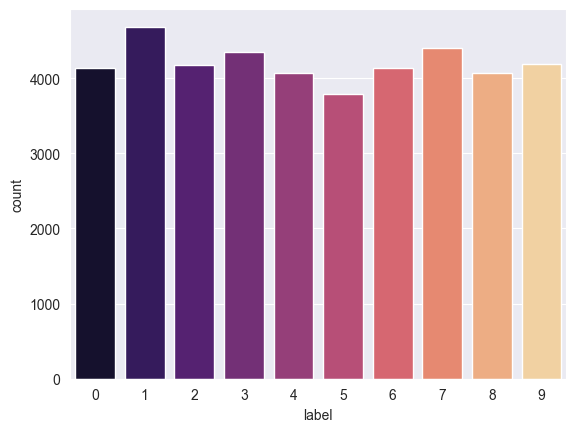

In [26]:
#visualizing the distribution of data , for each of the digits
sns.set_style('darkgrid')
sns.countplot(x='label',
              data=df_train[['label']],
              palette='magma')

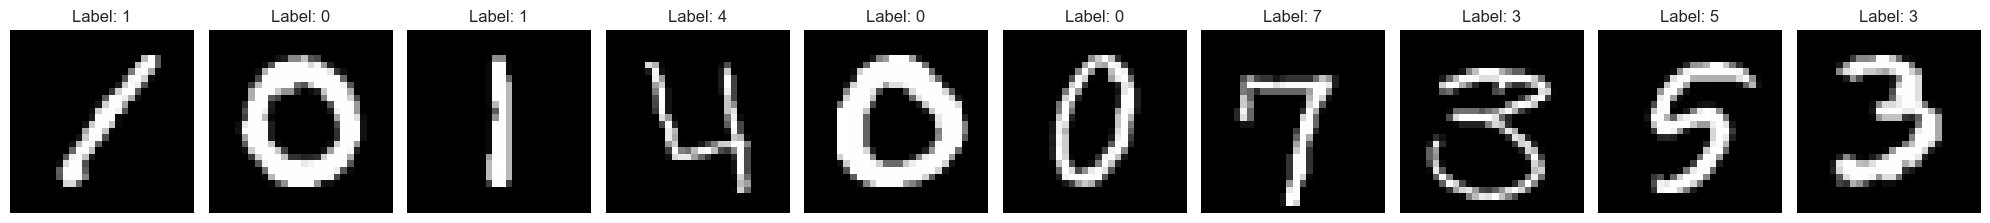

In [27]:
# Visualizing 10 images
num_images = 10
tensor = torch.tensor(Kaggle_train, dtype=torch.float32)
# Create a figure and axis for the images
fig, axes = plt.subplots(1, num_images, figsize=(20, 4))

# Loop through and display the selected images side by side
for i in range(num_images):
    img = tensor[i].view(28, 28).cpu().numpy()  # Convert to NumPy array
    img /= 255.0  # Normalize
    axes[i].imshow(img, cmap='gray')  # Display the grayscale image
    axes[i].set_title(f"Label: {Kaggle_label.values[i]}")
    axes[i].axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()

In [28]:
# Load the MNIST dataset from torchvision
MNIST_train = datasets.MNIST(root=extract,
                         train=True,
                         download=True,
                         transform = torchvision.transforms.ToTensor())
MNIS_test = datasets.MNIST(root=extract,
                          train=False,
                          download=True
                         )

In [29]:
# Merging torchvision MNIST training & test data
Mtrain_data = torch.cat([MNIST_train.data, MNIS_test.data], dim=0)
Mtrain_labels = torch.cat([MNIST_train.targets, MNIS_test.targets], dim=0)
# Converting MNIST Data to Numpy
Mtrain_numpy = Mtrain_data.numpy()
Mlabels_numpy = Mtrain_labels.numpy()
print(len(Mtrain_numpy))
print(len(Mlabels_numpy))

70000
70000


In [30]:
# Reshaping Kaggle Dataset
Kaggle_train1 = Kaggle_train.reshape(-1,28,28)
print(len(Kaggle_train1))
print(len(Kaggle_label))

42000
42000


In [31]:
# Merging Both Torchvision MNIST and Kaggle DataSet
X_train = np.concatenate((Kaggle_train1, Mtrain_numpy))
Y_train = np.concatenate((Kaggle_label, Mlabels_numpy))
print(len(X_train))
print(len(Y_train))


112000
112000


In [32]:
class ToTensorWithShape(object): # Custom transform to maintain shape
    def __call__(self, img):
        return torch.tensor(img, dtype=torch.float32).view(1, 28, 28)

transform = transforms.Compose([
    ToTensorWithShape(),  
    transforms.Normalize(mean=[0], std=[255])  # Normalize
])

# Custom Dataset
class Datasets(Dataset): 
  def __init__(self, X_train, y_train, transform = None):
    self.X_train = X_train
    self.y_train = y_train
    self.transform = transform

  def __len__(self):
    return len(self.X_train)

  def __getitem__(self, idx):
    image = self.X_train[idx]
    label = self.y_train[idx]

    if self.transform:
      image = self.transform(image)
    return image, label
data = Datasets(X_train=X_train,
                y_train=Y_train,
                transform=transform)
# DataLoader
Kaggle_loader = DataLoader(data,
                         batch_size=128,
                         shuffle=True)

In [33]:
torch.manual_seed(42)
# Convolutional Neural Network
class ConvNet(torch.nn.Module):

    def __init__(self, num_classes):
        super(ConvNet, self).__init__()

        # 28x28x1 => 28x28x8
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=8,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1) # (1(28-1) - 28 + 3) / 2 = 1
        # 28x28x8 => 14x14x8
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0) # (2(14-1) - 28 + 2) = 0
        # 14x14x8 => 14x14x16
        self.conv_2 = torch.nn.Conv2d(in_channels=8,
                                      out_channels=16,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1) # (1(14-1) - 14 + 3) / 2 = 1
        # 14x14x16 => 7x7x16
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0) # (2(7-1) - 14 + 2) = 0

        self.linear_1 = torch.nn.Linear(7*7*16, num_classes)

        # optionally initialize weights from Gaussian;
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
                m.weight.data.normal_(0.0, 0.01)
                m.bias.data.zero_()
                if m.bias is not None:
                    m.bias.detach().zero_()


    def forward(self, x):
        out = self.conv_1(x)
        out = F.relu(out)
        out = self.pool_1(out)

        out = self.conv_2(out)
        out = F.relu(out)
        out = self.pool_2(out)

        logits = self.linear_1(out.view(-1, 7*7*16))
        probas = F.softmax(logits, dim=1)
        return logits, probas



model = ConvNet(num_classes=10)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE) # SGD Optimizer

In [34]:
loss_fn = torch.nn.CrossEntropyLoss()

# Trained with 10 epochs and got training accuracy of 98.58%.

num_epochs = 10 # Recommended number of epochs is 30.

# Accuracy Function
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100



In [35]:
# CNN Training
start_time = time.time()
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(Kaggle_loader):

        features = features.to(device)
        targets = targets.to(device)

        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = loss_fn(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f'
                   %(epoch+1, num_epochs, batch_idx,
                     len(Kaggle_loader), cost))

    model = model.eval()
    print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
          epoch+1, num_epochs,
          compute_accuracy(model, Kaggle_loader)))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 000/875 | Cost: 2.3026
Epoch: 001/010 | Batch 050/875 | Cost: 2.3031
Epoch: 001/010 | Batch 100/875 | Cost: 2.3012
Epoch: 001/010 | Batch 150/875 | Cost: 2.3046
Epoch: 001/010 | Batch 200/875 | Cost: 2.3001
Epoch: 001/010 | Batch 250/875 | Cost: 2.3052
Epoch: 001/010 | Batch 300/875 | Cost: 2.2835
Epoch: 001/010 | Batch 350/875 | Cost: 2.0524
Epoch: 001/010 | Batch 400/875 | Cost: 1.1237
Epoch: 001/010 | Batch 450/875 | Cost: 0.4326
Epoch: 001/010 | Batch 500/875 | Cost: 0.3976
Epoch: 001/010 | Batch 550/875 | Cost: 0.4952
Epoch: 001/010 | Batch 600/875 | Cost: 0.3902
Epoch: 001/010 | Batch 650/875 | Cost: 0.3242
Epoch: 001/010 | Batch 700/875 | Cost: 0.4261
Epoch: 001/010 | Batch 750/875 | Cost: 0.3564
Epoch: 001/010 | Batch 800/875 | Cost: 0.2081
Epoch: 001/010 | Batch 850/875 | Cost: 0.2664
Epoch: 001/010 training accuracy: 93.05%
Time elapsed: 1.54 min
Epoch: 002/010 | Batch 000/875 | Cost: 0.1493
Epoch: 002/010 | Batch 050/875 | Cost: 0.2546
Epoch: 002/010 |

In [37]:
test_df = pd.read_csv(extract +'/test.csv')
test_df = test_df.values

In [38]:
def ImgNormalizer(df):
    normalize = df / 255
    reshape = normalize.reshape(-1, 1, 28, 28)
    tensor = torch.tensor(reshape, dtype = torch.float32)
    return tensor
test_data = ImgNormalizer(df=test_df)

In [39]:
all_predictions = []
model.eval()
with torch.no_grad():
  for i in tq.tqdm(test_data):
    x = i.unsqueeze(dim=0)
    x = x.to(device)
    logit, prob = model(x)
    prediction = prob.argmax()
    all_predictions.append(prediction.item())




100%|██████████| 28000/28000 [00:25<00:00, 1115.01it/s]


In [52]:
result = pd.Series(all_predictions, name='Label')
submission = pd.concat([pd.Series(range(1,28001), name='ImageId'), result], axis = 1)

In [55]:
submission.to_csv('submission.csv', index=False)

# This will earn you a score of 0.99+ on the Kaggle competition.